# Process Data Table over Lung Cancer Patient
Reference on [Process Description](https://www.notion.so/Causal-Analysis-over-Lung-Cancer-Patient-38668ea27d0e49df88791d7e4b841e98#e044372a34994bc9b547b7e4994d33f5)

# Data Processing into 'generated' directory

In the relational database, each patient doesn't have multiple records for same family with same cancer. 
For example, we don't have patient1 who has 2 aunt with breast cancer

SELECT t.ehr, COUNT(CONCAT(t.family_member, ',', t.cancer_type)) as num, COUNT(DISTINCT CONCAT(t.family_member, ',', t.cancer_type)) as uniq_num FROM `family_antecedents_treatment_line` t group by t.ehr,t.treatment_line ORDER by num DESC

In [16]:
import pandas as pd
df = pd.read_csv('family_antecedents_treatment_line.csv')
df = df.fillna('NULL')

for col in ["FamilyCancer","FamilyGenderDegree","FamilyDegree","Family"]:
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x: x.strip())
df.to_csv("family_cancer_degree.csv", index=False)

In [17]:
import pandas as pd
import numpy as np
import copy
from collections import Counter
import math
import numbers
from itertools import combinations

def val(raw_in):
    if isinstance(raw_in, numbers.Number):
        if math.isnan(float(raw_in)):
            return "NULL"
        else:
            return int(raw_in)
    elif isinstance(raw_in, str) and raw_in.isnumeric():
        return int(float(raw_in))
    else:
        return 'NULL'

def family_num_fun():
    '''
    "Patient_id","FamilyNum","FamilyDiversity","LungNum","OtherNum"
    '''
    dataf = {"Patient_id":[], "FamilyNum":[], 'LungNum':[], 'OtherNum':[]}
    has_family_number = pd.read_csv('hasfamily.csv')                        # `family_antecedents` number of cancered family
    patient_family_cancer = pd.read_csv('patient_family_cancer.csv')        # `family_antecedents_treatment_line` only for diversity because a aunt can have multiple cancers

    df1 = copy.deepcopy(has_family_number)
    
    for i, row in df1.iterrows():
        p_id = int(row[0])
        hasfam = -1 if math.isnan(float(row[1])) else int(row[1])
        
        if hasfam == 1:
            lung_num = val(row[2])
            other_num = val(row[3])
        elif hasfam == 0:
            lung_num, other_num = 0, 0
        elif hasfam == -1:
            lung_num, other_num = 'NULL', 'NULL'  
        else:
            raise Exception("has fam must in [-1, 1]")

        # print(p_id, hasfam, lung_num, other_num)
        dataf['Patient_id'].append(p_id)
        dataf['FamilyNum'].append((lung_num + other_num) if (isinstance(lung_num, numbers.Number) and isinstance(other_num, numbers.Number)) else 'NULL')
        dataf['LungNum'].append(lung_num)
        dataf['OtherNum'].append(other_num)
    
    df1 = pd.DataFrame(dataf)
    df1.drop_duplicates(inplace=True)

    df2 = copy.deepcopy(patient_family_cancer)
    df2 = df2.fillna('UNK')                     # when cancer type == '-' and Family = NULL or UNK
    df2['FamilyDiversity']=df2.groupby('EHR')['Family'].transform('nunique')
    df2 = df2[['EHR', 'FamilyDiversity']]
    df2.rename(columns={"EHR": "Patient_id"}, inplace=True)
    df2.drop_duplicates(inplace=True)

    df = pd.merge(left=df1, right=df2, on='Patient_id', how='outer')
    df = df.drop_duplicates()
    df = df.fillna('NULL')

    # family_num >= family_diversity
    f_num_ls = []
    for i, row in df[['FamilyNum', 'FamilyDiversity']].iterrows():
        f_num, f_divers = val(row[0]), val(row[1])
        if isinstance(f_num, numbers.Number) and isinstance(f_divers, numbers.Number):
            f_num_ls.append(f_divers if f_divers > f_num else f_num)
        elif not isinstance(f_num, numbers.Number) and isinstance(f_divers, numbers.Number):
            f_num_ls.append(f_divers)
        else:
            f_num_ls.append(f_num)
    
    df['FamilyNum'] = f_num_ls
    print('number of rows:', len(df), '\t number of ids:', len(df.Patient_id))
    df.to_csv('genereated/family_num.csv', index=False)


def age_gender_smoker_type():
    '''
    "CancerType", "Gender", "Age", "Smoker"
    '''
    p_age = pd.read_csv('patient_age.csv')
    p_gender = pd.read_csv('patient_gender.csv')
    p_smoker = pd.read_csv('patient_smoker.csv')
    # p_type = pd.read_csv('patient_type.csv')

    df = pd.merge(left=p_age, right=p_gender, on='EHR', how='outer')
    df = pd.merge(left=df, right=p_smoker, on='EHR', how='outer')
    # df = pd.merge(left=df, right=p_type, on='EHR', how='outer')
    df.drop_duplicates(inplace=True)

    # Gender
    df.Gender = df.Gender.str.strip()
    
    # Smoker
    df.Smoker = df.Smoker.apply(lambda x: 'Never-Smoker' if x==0 else "Former-Smoker" if x==1 else "Current-Smoker" if x==2 else 'NULL')
    
    # SmokeExposure
    never_exposured_ids = set(df.loc[(df.SmokerLive + df.HasSmokerLived ==  0.0)].EHR)
    have_exposured_ids = set(df.loc[(df.SmokerLive==1.0) | (df.HasSmokerLived == 1.0)].EHR)
    df['SmokeExposure'] = ['NULL']*len(df)
    df['SmokeExposure'] = df['SmokeExposure'].mask(df.EHR.isin(never_exposured_ids), 'NoExposured')
    df['SmokeExposure'] = df['SmokeExposure'].mask(df.EHR.isin(have_exposured_ids), 'Exposured')
    # # CancerType
    # df.CancerType = df.CancerType.astype(str)
    # df.CancerType = df.CancerType.apply(lambda x: 'NSCL' if 'Non small' in x else 'SCL' if 'Small' in x else 'Other')
    # {'Non small cell lung cancer': 12981, 'Small cell lung cancer': 1988, 'Carcinoid tumor': 91, 'Epithelial thumic tumor': 57, 'Mesothelyoma': 143, 'Others': 69, '-': 1, nan: 7}
    
    df.drop(columns=['SmokerLive', 'HasSmokerLived'], inplace=True)
    df = df.fillna('NULL')
    df.rename(columns={'EHR': 'Patient_id'}, inplace=True)
    df = df.drop_duplicates()
    print('number of rows:', len(df), '\t number of ids:', len(df.Patient_id))
    df.to_csv("genereated/gender_age_smoker_type.csv", index=False)


def mutation():
    ''' Patient_id, Mutation
	'''
    df = pd.read_csv("patient_mutation.csv")
    df = df.rename(columns={'Mutation': 'Biomarker'})
    df = df.drop_duplicates()
    df.to_csv('genereated/mutation.csv',index=False)

def family():
    ''' Patient_id,FamilyCancer,FamilyDegree,Family,FamilyGender
	'''
    df = pd.read_csv('patient_family_cancer.csv')

    df.FamilyDegree = df.FamilyDegree.astype(str).apply(lambda x: '1st' if 'First' in x else '2nd' if 'Second' in x else '3rd' if 'Third' in x else 'UNK' if 'UNK' in x else 'NULL')
    df['FamilyGender'] = df.FamilyGenderDegree.astype(str).apply(lambda x: 'Male' if 'Male' in x else 'Female' if 'Female' in x else 'UNK' if 'UNK' in x else 'NULL')
    df.FamilyCancer = df.FamilyCancer.astype(str).apply(lambda x: x.strip())
    df.drop(columns=['FamilyGenderDegree'], inplace=True)
    df = df.fillna('UNK')
    df = df.replace({"NULL": "UNK", '-': 'UNK'})
    df.rename(columns={'EHR': 'Patient_id'}, inplace=True)
    df = df.drop_duplicates()
    print('number of rows:', len(df), '\t number of ids:', len(df.Patient_id))
    df.to_csv("genereated/family.csv", index=False)

# family()
# df = pd.read_csv('patient_family_cancer.csv')
# Counter(df.Family)
# Counter(df.FamilyCancer.astype(str).apply(lambda x: x.strip()))
# print(df.columns)
# Counter(df.FamilyGenderDegree)

# p_type = pd.read_csv('patient_type.csv')
# Counter(p_type['CancerType'])

# p_smoker = pd.read_csv('patient_smoker.csv')
# p_smoker.SmokerLive = p_smoker.SmokerLive.astype(float)
# p_smoker.HasSmokerLived = p_smoker.HasSmokerLived.astype(float)
# df = p_smoker
# # df['SmokerLive']+df['HasSmokerLived'] == 0.0
# never_exposured_ids = set(df.loc[(df.SmokerLive + df.HasSmokerLived ==  0.0)].EHR)

# df = p_smoker.loc[(p_smoker.SmokerLive.notna()) & (p_smoker.HasSmokerLived.notna())]
# # df['SmokerLive']+df['HasSmokerLived']
# Counter(df.apply(lambda row: str(row.SmokerLive)+str(row.HasSmokerLived), axis=1))

# [['SmokerLive', 'HasSmokerLived']].apply(lambda x: sum(x))

# df1 = patient_family_cancer
# df1['FamilyDiveristy'] = df1.groupby('EHR').Family.transform('nunique')

# df1 = has_family_number
# df1.loc[(df1.hasFamily.isin([np.nan]))]
# Counter(has_family_number.hasFamily)


In [25]:
family_num_fun()
age_gender_smoker_type()
mutation()
family()

number of rows: 15337 	 number of ids: 15337
number of rows: 15337 	 number of ids: 15337
number of rows: 11352 	 number of ids: 11352


# Checking

In [2]:
# 1. single value
import pandas as pd
family_num = pd.read_csv('genereated/family_num.csv')
gender_age_smoker_type_df = pd.read_csv('genereated/gender_age_smoker_type.csv')
age_threshold = 50
gender_age_smoker_type_df.Age = gender_age_smoker_type_df.Age.apply(lambda x: 'Young' if x <= age_threshold else 'Old' if x > age_threshold else "UNK")
# 2. multi-vlaue
mutation_df = pd.read_csv('genereated/mutation.csv')

df1 = pd.merge(gender_age_smoker_type_df, mutation_df, on='Patient_id', how='inner')
df1 = df1.loc[(~df1.Age.isnull()) & (df1.Age != 'UNK') & (~df1.Gender.isnull()) & (~df1.Biomarker.isnull())]
# df1.groupby(['Gender', 'Age'])['Patient_id'].nunique()
df1.groupby(['Gender', 'Age', 'Biomarker'])['Patient_id'].nunique()

Gender  Age    Biomarker 
Female  Old    ALK            108
               BRAF            12
               EGFR           616
               FGFR1            1
               HER2             2
               HER2Mut          1
               KRAS            66
               MET              5
               NoMutation     850
               PDL1           552
               RET              1
               ROS1            30
        Young  ALK             46
               BRAF             2
               EGFR            66
               KRAS            10
               MET              2
               NoMutation     132
               PDL1            70
               ROS1             5
Male    Old    ALK            106
               BRAF            24
               EGFR           404
               FGFR1            2
               HER2             3
               KRAS           151
               MET              7
               NoMutation    2878
               PDL1   

In [9]:
import pandas as pd
import re

df1 = pd.read_csv("mutation_sql.csv").fillna('')
df2 = pd.read_csv('genereated/mutation.csv').fillna('')

print(len(df1.EHR.unique()), ' vs ', len(df2.Patient_id.unique()))
print(len(df1),'=',len(df2))

set1 = set(df1['EHR'].astype('str') + df1['Biomarker'].astype('str'))
set2 = set(df2.Patient_id.astype('str') + df2.Biomarker.astype('str'))

print(len(set1.intersection(set2)))
print(len(set1.difference(set2)))
print(len(set2.difference(set1)))

print([int(e1) for e in set2.difference(set1) if 'NoM' not in e and not e.isdigit() for e1 in re.findall(r'\d+',e)])


15337  vs  15337
15748 = 17369
15748
0
934
[311537, 1309485, 5115342, 2, 201803, 204005, 704307, 5112572, 1, 4605313, 715074, 501233, 702150, 11311899, 208872, 1300690, 715150, 1301994, 5112572, 2, 1300706, 212746, 9912929, 6301668, 1, 1315486, 11311899, 11311899, 2, 4600168, 202405, 207746, 410199, 5115342, 4601468, 702149, 1302232, 1303483, 715150, 215667, 704849, 5112572, 206054, 6605627, 4605636, 501249, 4608612, 707609, 701644, 201695, 9912929, 1512705, 6611284, 9912929, 715073, 712819, 4603819, 4605942, 2811959, 2811959, 2811959, 1305517, 11314104, 704661, 4602350, 5115342, 1, 204193, 207226, 703768, 410199, 1304431, 207049, 712819, 5115342, 715074, 2305849, 4613026, 410199, 1300790, 715074, 206752, 1313362, 6301668, 203710, 5112572, 1309865, 201568, 715150, 514182, 9910148, 410199, 2, 3407245, 6605730, 201951, 1305534, 715073, 5112572, 702911, 201453, 207295, 1303478, 4614857, 1305529, 9912929, 410199, 709156, 703754, 701617, 11314107, 4613261, 205559, 715073, 6605729, 1315173, 

# Jacard Index Analysis

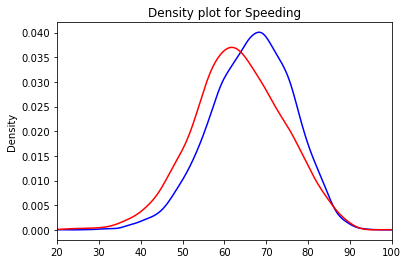

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('genereated/gender_age_smoker_type.csv')
# age_threshold =50
# print(df.loc[(~df.Age.notna())].Age.apply(lambda x: 'Young' if x <= age_threshold else 'Old' if x > age_threshold else "UNK"))

df = df.loc[(df.Age.notna())]

df.loc[(df.Gender == 'Male')].Age.plot.density(color='blue')
df.loc[(df.Gender == 'Female')].Age.plot.density(color='red')
plt.xlim([20, 100])
plt.title('Density plot for Speeding')
plt.show()



In [ ]:
gender_age_smoker_type_df = pd.read_csv('genereated/gender_age_smoker_type.csv')

In [3]:
import pandas as pd
import numpy as np
import copy
from collections import Counter
import math
import numbers
from itertools import combinations

In [8]:
# context: gender, age (cancer type)
# analysis: smoker, mutation, jacard index

##########################################################################################
##                                      patient's info
##########################################################################################
# 1. single value
family_num = pd.read_csv('genereated/family_num.csv')
gender_age_smoker_type_df = pd.read_csv('genereated/gender_age_smoker_type.csv')
age_threshold = 50
gender_age_smoker_type_df.Age = gender_age_smoker_type_df.Age.apply(lambda x: 'Young' if x <= age_threshold else 'Old' if x > age_threshold else "UNK")
# 2. multi-vlaue
mutation_df = pd.read_csv('genereated/mutation.csv')

##########################################################################################
##                                      relative's info
##########################################################################################
relative_df = pd.read_csv('genereated/family.csv')


def sub_pop(gender=None, age=None, biomarker=None):
    df = copy.deepcopy(gender_age_smoker_type_df)
    
    if gender:
        if gender not in df.Gender.unique():
            raise Exception("the value of Gender {gender} is not acceptable")
        # df = df.loc[(df.Gender.notna())]
        df = df.loc[(df.Gender == gender)]
    if age:
        # df = df.loc[(df.Age.notna())]
        if age not in df.Age.unique():
            raise Exception("the value of Age {age} is not acceptable")
        df = df.loc[(df.Age == age)]
    
    if biomarker:
        if biomarker not in mutation_df.Biomarker.unique():
            raise Exception("the value of biomarker {biomarker} is not acceptable")
        p_ids = set(mutation_df.loc[(mutation_df.Biomarker == biomarker)].Patient_id)
        df = df.loc[(df.Patient_id.isin(p_ids))]
    
    # print('total sub_pop:', len(df.Patient_id.unique()))
    # sub population
    p_ids = set(df.Patient_id)
    # max_family_number
    max_fmaily_num = family_num.loc[(family_num.Patient_id.isin(p_ids))].FamilyNum.max()
    return df, max_fmaily_num


def get_normalized_family_cancer(df, max_fmaily_num, allow_mutation=[]):
    '''
    add family_cancer connection number,
    add mutation information
    '''
    # family info
    # those who has cancered family
    df1 = relative_df.loc[(relative_df.Family.notna())][['Patient_id', 'Family']]
    df1['family_cancer_num'] = df1.groupby('Patient_id')['Family'].transform('count')
    # those who don't have cancered family
    df2 = family_num.loc[(family_num.FamilyNum == 0) & (~family_num.Patient_id.isin(df1.Patient_id))][['Patient_id', 'FamilyNum']]
    df2.rename(columns={'FamilyNum': 'family_cancer_num'}, inplace=True)
    
    df = pd.merge(left=df, right=pd.concat([df1,df2]), on='Patient_id', how='inner') # family information must be known -> inner
    
    # Jacard index
    df['Normalized Familial Cancer Frequency'] = df['family_cancer_num'] / df['family_cancer_num'].max()
    
    # mutation info
    df = pd.merge(left=df, right=mutation_df, on='Patient_id', how='inner') # inner
    if allow_mutation:
        df = df.loc[(df.Biomarker.isin(allow_mutation))]
    return df

def jaccard(ls1:list, ls2:list):
    s1 = set(ls1)
    s2 = set(ls2)
    c1 = Counter(ls1)
    c2 = Counter(ls2)

    up = 0
    down = 0
    for e in s1.intersection(s2):
        up += min(c1[e], c2[e])
        down += max(c1[e], c2[2])
    return 0.0 if up == 0 else up / (down + sum([c1[e] for e in s1.difference(s2)]) + sum([c2[e] for e in s2.difference(s1)]))

def Jaccard_df(df1, simple_version=True, jacard_choice=0):
    
    if jacard_choice == 0:  # family type + cancer type
        df1 = df1.loc[(df1.FamilyCancer != 'UNK') & (df1.Family != 'UNK') & (df1.Family.notna()) & (df1.FamilyCancer.notna())]
        df1['jacard_attribute'] = df1['Family']+ df1['FamilyCancer']
    elif jacard_choice == 1:    # fanily type
        df1 = df1.loc[(df1.Family != 'UNK') & (df1.Family.notna())]
        df1['jacard_attribute'] = df1['Family']
    elif jacard_choice == 2:    # cancer type
        df1 = df1.loc[(df1.FamilyCancer != 'UNK') & (df1.FamilyCancer.notna())]
        df1['jacard_attribute'] = df1['FamilyCancer']
    elif jacard_choice == 3:    # degree
        df1 = df1.loc[(df1.FamilyDegree != 'UNK') & (df1.FamilyDegree.notna())]
        df1['jacard_attribute'] = df1['FamilyDegree']
    elif jacard_choice == 4:    # degree + cancer type
        df1 = df1.loc[(df1.FamilyDegree != 'UNK') & (df1.FamilyCancer != 'UNK') & (df1.FamilyCancer.notna()) & (df1.FamilyDegree.notna())]
        df1['jacard_attribute'] = df1['FamilyDegree'] + df1['FamilyCancer']
    elif jacard_choice == 5:    # gender
        df1 = df1.loc[(df1.FamilyGender != 'UNK') & (df1.FamilyGender.notna())]
        df1['jacard_attribute'] = df1['FamilyGender']
    elif jacard_choice == 6:    # gender + cancer
        df1 = df1.loc[(df1.FamilyGender != 'UNK') & (df1.FamilyCancer != 'UNK') & (df1.FamilyCancer.notna()) & (df1.FamilyGender.notna())]
        df1['jacard_attribute'] = df1['FamilyGender'] + df1['FamilyCancer']
    else:
        raise Exception("No such a choice={choice}")
    
    pop_ids = set(df1.Patient_id.unique())
    family_cancer_series = df1.groupby('Patient_id').apply(lambda x: x.jacard_attribute.tolist())
    result_df = {'Familial Cancer Connectedness':[]}
    
    for p_id1, p_id2 in list(combinations(df1.Patient_id.unique().tolist(), 2)):

        list1 = family_cancer_series[p_id1]
        list2 = family_cancer_series[p_id2]
        s1 = set(list1)
        s2 = set(list2)
        jaccard_val = 0 if len(s1) == 0 or len(s2) == 0 else len(s1.intersection(s2))/len(s1.union(s2)) if simple_version else jaccard(list1, list2)
        
        if np.isnan(jaccard_val):
            raise Exception("s1:", s1, "s2", s2)
        result_df['Familial Cancer Connectedness'].append(jaccard_val)
    
    result_df = pd.DataFrame(result_df)
    # print( gender, age, smoker, biomarker, "\t\tpop size", len(df1.Patient_id.unique()), '\t\tavg-Jaccard:', '{:.4f}'.format(result_df['Familial Cancer Connectedness'].mean()))
    return result_df, pop_ids


def box_plot(df, y_var, x_var, hue_var, title, fn):
    import seaborn as sns
    import matplotlib.pyplot as plt
    # from aquarel import load_theme

    # theme = load_theme("arctic_light")
    # theme.apply()

    sns.set_theme(style="ticks", palette="husl")
    sns.set_palette("pastel")
    
    # Draw a nested boxplot to show bills by day and time
    ax = sns.boxplot(x=x_var, y=y_var,
                hue=hue_var, 
                hue_order=["Never-Smoker", "Former-Smoker", 'Current-Smoker'],
                order=sorted(df[x_var].unique().tolist()),
                palette={"Never-Smoker": "green", "Former-Smoker": "blue", 'Current-Smoker': "red"},
                data=df)
    ax.set(title = title)
    # plt.subplots_adjust(left=0.05, right=0.05, top=0.05, bottom=0.05)   # 图片边缘距离
    plt.subplots_adjust(bottom=0.25)   # 图片边缘距离
    if max([len(e) for e in df[x_var].unique()]) > 7:
        plt.setp(ax.get_xticklabels(), rotation=25)
    # plt.legend(loc='upper right')
    # if len(df) > 0:
    #     high = df.groupby('')[y_var].quantile([0.25,0.5,0.75]).tolist()[-1]
    # plt.ylim([0, df[y_var].max()+0.13])
    plt.ylim([0, 1+0.13])
    # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper right', borderaxespad=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, framealpha=0.5, shadow=False, fontsize=9)
    # theme.apply_transforms()
    ax.get_figure().savefig(fn)
    plt.clf()
    # sns.despine(offset=10, trim=True)

# ['ALK', 'BRAF', 'EGFR', 'FGFR1', 'HER2', 'HER2Mut', 'KRAS', 'MET', 'NTKR', 'NoMutation', 'PDL1', 'RET', 'ROS1']

# Counter(mutation_df.loc[(mutation_df.Biomarker.notna())].Biomarker)



# Normalized Familial Cancer Frequency

In [9]:
for gender in ['Male', 'Female']:
        for age in ['Old', 'Young']:
            for biomarker in ['ALK', 'BRAF', 'EGFR', 'KRAS', 'MET', 'NoMutation', 'PDL1', 'ROS1', 'FGFR1', 'HER2', 'HER2Mut', 'RET']:
                df, max_family_num = sub_pop(gender=gender, age=age, biomarker=biomarker)
                print(gender, age, biomarker, len(df.Patient_id.unique()))

Male Old ALK 106
Male Old BRAF 24
Male Old EGFR 404
Male Old KRAS 151
Male Old MET 7
Male Old NoMutation 2878
Male Old PDL1 1589
Male Old ROS1 36
Male Old FGFR1 2
Male Old HER2 3
Male Old HER2Mut 0
Male Old RET 1
Male Young ALK 29
Male Young BRAF 2
Male Young EGFR 50
Male Young KRAS 10
Male Young MET 2
Male Young NoMutation 196
Male Young PDL1 99
Male Young ROS1 4
Male Young FGFR1 0
Male Young HER2 0
Male Young HER2Mut 1
Male Young RET 0
Female Old ALK 108
Female Old BRAF 12
Female Old EGFR 616
Female Old KRAS 66
Female Old MET 5
Female Old NoMutation 850
Female Old PDL1 552
Female Old ROS1 30
Female Old FGFR1 1
Female Old HER2 2
Female Old HER2Mut 1
Female Old RET 1
Female Young ALK 46
Female Young BRAF 2
Female Young EGFR 66
Female Young KRAS 10
Female Young MET 2
Female Young NoMutation 132
Female Young PDL1 70
Female Young ROS1 5
Female Young FGFR1 0
Female Young HER2 0
Female Young HER2Mut 0
Female Young RET 0


In [32]:
set(mutation_df.Biomarker.unique())-set(['ALK', 'BRAF', 'EGFR', 'KRAS', 'MET', 'NoMutation', 'PDL1', 'ROS1'])

{'FGFR1', 'HER2', 'HER2Mut', 'RET', nan}

In [37]:
def family_cancer_frequency():
    import os
    for gender in ['Male', 'Female']:
        for age in ['Old', 'Young']:
            df, max_family_num = sub_pop(gender=gender, age=age)
            
            df = get_normalized_family_cancer(df, max_family_num, allow_mutation=['ALK', 'BRAF', 'EGFR', 'KRAS', 'MET', 'NoMutation', 'PDL1', 'ROS1', 'FGFR1', 'HER2', 'HER2Mut', 'RET'])
            pop_size = len(df.Patient_id.unique())
            # print(df.groupby('Mutation')['Normed_Jacard'].count())
            # print('jacard_index/age={age}/Family_Cancer_Frequency/'.format(age_threshold=age_threshold))
            if not os.path.exists('jacard_index/age={age_threshold}'.format(age_threshold=age_threshold)):
                os.mkdir('jacard_index/age={age_threshold}'.format(age_threshold=age_threshold))
            if not os.path.exists('jacard_index/age={age_threshold}/Family_Cancer_Frequency/'.format(age_threshold=age_threshold)):
                    os.mkdir('jacard_index/age={age_threshold}/Family_Cancer_Frequency/'.format(age_threshold=age_threshold))
            title = age+"-"+gender+" (age"+((" <= "+str(age_threshold)) if age == 'Young' else (" > "+str(age_threshold)))+")    pop-size="+str(pop_size)
            box_plot(df, y_var='Normalized Familial Cancer Frequency', x_var='Biomarker', hue_var='Smoker', title=title, fn='jacard_index/age={age_threshold}/Family_Cancer_Frequency/'.format(age_threshold=age_threshold)+title+".png")

In [38]:
family_cancer_frequency()

total sub_pop: 9925
total sub_pop: 611
total sub_pop: 3223
total sub_pop: 415


<Figure size 432x288 with 0 Axes>

# Jacard Index

## Jaccard Index x=biomarker

In [22]:
def jaccard_x_is_bio():
    import os
    # df = pd.merge(gender_age_smoker_type_df, mutation_df, on='Patient_id', how='outer')
    # df = pd.merge(df, relative_df, on='Patient_id', how='outer')
    # print(df.columns)
    
    for gender in ['Male', 'Female']:
        for age in ['Old', 'Young']:
            for choice, choice_describe in {0: "Family Type + Familial Cancer Type", 1:"Family Type", 2: "Familial Cancer Type", 3: "Degree", 4: "Degree + Familial Cancer Type",
                                            5: 'Familial Gender', 6: "Familial Gender + Familial Cancer Type"}.items():
                pop_ids = set()
                df_analysis = pd.DataFrame({'Familial Cancer Connectedness':[], 'Smoker':[], 'Biomarker':[]})
                
                for smoker in ['Never-Smoker', 'Former-Smoker', 'Current-Smoker']:
                    for biomarker in ['ALK', 'BRAF', 'EGFR', 'KRAS', 'MET', 'NoMutation', 'PDL1', 'ROS1']:
                        p_ids = set(gender_age_smoker_type_df.loc[(gender_age_smoker_type_df.Gender==gender) & (gender_age_smoker_type_df.Age==age) & (gender_age_smoker_type_df.Smoker == smoker)].Patient_id)
                        p_ids = p_ids.intersection(set(mutation_df.loc[(mutation_df.Biomarker == biomarker)].Patient_id))
                        
                        df1 = relative_df.loc[relative_df.Patient_id.isin(p_ids)]
                        df2, sub_pop_ids = Jaccard_df(df1, simple_version=False, jacard_choice=choice)
                        
                        df2['Smoker'] = [smoker]*len(df2)
                        df2['Biomarker'] = [biomarker]*len(df2)
                        df_analysis = pd.concat([df_analysis, df2])
                        pop_ids = pop_ids | sub_pop_ids
                if not os.path.exists('jacard_index/age={age_threshold}'.format(age_threshold=age_threshold)):
                    os.mkdir('jacard_index/age={age_threshold}'.format(age_threshold=age_threshold))
                if not os.path.exists('jacard_index/age={age_threshold}/Jaccard_X_is_Biomarker/'.format(age_threshold=age_threshold)):
                    os.mkdir('jacard_index/age={age_threshold}/Jaccard_X_is_Biomarker/'.format(age_threshold=age_threshold))
                if not os.path.exists('jacard_index/age={age_threshold}/Jaccard_X_is_Biomarker/'.format(age_threshold=age_threshold)+choice_describe):
                    os.mkdir('jacard_index/age={age_threshold}/Jaccard_X_is_Biomarker/'.format(age_threshold=age_threshold)+choice_describe)
                title = age+"-"+gender+" (age"+((" <= "+str(age_threshold)) if age == 'Young' else (" > "+str(age_threshold)))+")    pop-size="+str(len(pop_ids))

                box_plot(df_analysis, y_var='Familial Cancer Connectedness', x_var='Biomarker', hue_var='Smoker', title=title, fn='jacard_index/age={age_threshold}/Jaccard_X_is_Biomarker/'.format(age_threshold=age_threshold)+choice_describe+"/"+title+".png")


## Jaccard Index for biomarker (ALK,EGFR), x=cancer

In [23]:
def jaccard_x_is_cancer():
    import os
    # df = pd.merge(gender_age_smoker_type_df, mutation_df, on='Patient_id', how='outer')
    # df = pd.merge(df, relative_df, on='Patient_id', how='outer')
    # print(df.columns)

    for gender in ['Male', 'Female']:
        for age in ['Old', 'Young']:
            for biomarker in ['ALK', 'EGFR']:
                for choice, choice_describe in {0: "Family Type + Familial Cancer Type", 1:"Family Type", 2: "Familial Cancer Type", 3: "Degree", 4: "Degree + Familial Cancer Type",
                                                5: 'Familial Gender', 6: "Familial Gender + Familial Cancer Type"}.items():
                    if 'Cancer' in choice_describe:
                        continue
                    
                    pop_ids = set()
                    df_analysis = pd.DataFrame({'Familial Cancer Connectedness':[], 'Familial Cancer':[], 'Smoker':[]})
                    
                    for cancer in ['Leukemia','Liver','Uterus/cervical','Pancreatic','Prostate','Head and neck','Esophagogastric','Colorrectal','Breast','Lung']:
                        for smoker in ['Never-Smoker', 'Former-Smoker', 'Current-Smoker']:
                            p_ids = set(gender_age_smoker_type_df.loc[(gender_age_smoker_type_df.Gender==gender) & (gender_age_smoker_type_df.Age==age) & (gender_age_smoker_type_df.Smoker == smoker)].Patient_id)
                            p_ids = p_ids.intersection(set(mutation_df.loc[(mutation_df.Biomarker == biomarker)].Patient_id))
                            p_ids = p_ids.intersection(set(relative_df.loc[(relative_df.FamilyCancer==cancer)].Patient_id))
                            
                            df1 = relative_df.loc[relative_df.Patient_id.isin(p_ids)]
                            # df1 = df.loc[(df.Gender==gender) & (df.Age==age) & (df.Biomarker == biomarker) & (df.Smoker == smoker) & (df.FamilyCancer==cancer)]
                            df2, sub_pop_ids = Jaccard_df(df1, simple_version=False, jacard_choice=choice)
                            
                            df2['Familial Cancer'] = [cancer]*len(df2)
                            df2['Smoker'] = [smoker]*len(df2)
                            df_analysis = pd.concat([df_analysis, df2])
                            pop_ids = pop_ids | sub_pop_ids
                    # print("pop_size", pop_size)
                    title = age+"-"+gender+"-"+biomarker+" (age"+((" <= "+str(age_threshold)) if age == 'Young' else (" > "+str(age_threshold)))+")    pop-size="+str(len(pop_ids))
                    if not os.path.exists('jacard_index/age={age_threshold}'.format(age_threshold=age_threshold)):
                        os.mkdir('jacard_index/age={age_threshold}'.format(age_threshold=age_threshold))
                    if not os.path.exists('jacard_index/age={age_threshold}/Jaccard_X_is_Cancer/'.format(age_threshold=age_threshold)):
                        os.mkdir('jacard_index/age={age_threshold}/Jaccard_X_is_Cancer/'.format(age_threshold=age_threshold))
                    if not os.path.exists('jacard_index/age={age_threshold}/Jaccard_X_is_Cancer/'.format(age_threshold=age_threshold)+choice_describe):
                        os.mkdir('jacard_index/age={age_threshold}/Jaccard_X_is_Cancer/'.format(age_threshold=age_threshold)+choice_describe)
                    if not os.path.exists(os.path.join('jacard_index/age={age_threshold}/Jaccard_X_is_Cancer/'.format(age_threshold=age_threshold)+choice_describe, biomarker)):
                        os.mkdir(os.path.join('jacard_index/age={age_threshold}/Jaccard_X_is_Cancer/'.format(age_threshold=age_threshold)+choice_describe, biomarker))
                    
                    box_plot(df_analysis, y_var='Familial Cancer Connectedness', x_var='Familial Cancer', hue_var='Smoker', title=title, 
                    fn=os.path.join('jacard_index/age={age_threshold}/Jaccard_X_is_Cancer/'.format(age_threshold=age_threshold)+choice_describe, biomarker,title+".png"))



# Generate all graph
remember to change the age_threshold

In [31]:
family_cancer_frequency()
jaccard_x_is_bio()
jaccard_x_is_cancer()

total sub_pop: 9925
total sub_pop: 611
total sub_pop: 3223
total sub_pop: 415


/var/folders/xg/sgltsf_10ts6qmw9vglkmqyc0000gp/T/ipykernel_29210/2759092638.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['jacard_attribute'] = df1['Family']+ df1['FamilyCancer']
/var/folders/xg/sgltsf_10ts6qmw9vglkmqyc0000gp/T/ipykernel_29210/2759092638.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['jacard_attribute'] = df1['Family']+ df1['FamilyCancer']
/var/folders/xg/sgltsf_10ts6qmw9vglkmqyc0000gp/T/ipykernel_29210/2759092638.py:90: SettingWithCopyWarning: 
A value is trying to be 

<Figure size 432x288 with 0 Axes>

# Testing the Jaccard Computation Correctness

In [50]:
# 1. single value
family_num = pd.read_csv('genereated/family_num.csv')
gender_age_smoker_type_df = pd.read_csv('genereated/gender_age_smoker_type.csv')
age_threshold = 50
gender_age_smoker_type_df.Age = gender_age_smoker_type_df.Age.apply(lambda x: 'Young' if x <= age_threshold else 'Old' if x > age_threshold else "UNK")
# 2. multi-vlaue
mutation_df = pd.read_csv('genereated/mutation.csv')
# relatives
relative_df = pd.read_csv('genereated/family.csv')

cancers = ['Leukemia','Liver','Uterus/cervical','Pancreatic','Prostate','Head and neck','Esophagogastric','Colorrectal','Breast','Lung']

def f(gender, age, biomarker):
    p_ids = set(gender_age_smoker_type_df.loc[(gender_age_smoker_type_df.Gender==gender) & (gender_age_smoker_type_df.Age==age)].Patient_id)
    print('{gender}+{age}:', len(p_ids))
    p_ids = p_ids.intersection(set(mutation_df.loc[(mutation_df.Biomarker == biomarker)].Patient_id))
    print('{gender}+{age}+{biomarker}:', len(p_ids))
    p_ids = p_ids.intersection(set(relative_df.loc[(relative_df.FamilyCancer.isin(cancers))].Patient_id))
    print('{gender}+{age}+{biomarker}+Cancer:', len(p_ids))
    left = gender_age_smoker_type_df.loc[(gender_age_smoker_type_df.Patient_id.isin(p_ids))]
    right = relative_df.loc[(relative_df.Patient_id.isin(p_ids))]
    # print(left)
    # print("-----------------\n")
    # print(right)
    df = pd.merge(left=left, right=right, on='Patient_id', how='inner')
    return df.drop(columns=['CancerType','SmokeExposure']).sort_values(['FamilyCancer','Smoker'])


f('Male', 'Young', 'ALK')
# 705299


{gender}+{age}: 611
{gender}+{age}+{biomarker}: 29
{gender}+{age}+{biomarker}+Cancer: 11


,Patient_id,Age,Gender,Smoker,FamilyCancer,FamilyDegree,Family,FamilyGender
16,705299,Young,Male,Current-Smoker,Breast,2nd,Aunt,Female
0,10802980,Young,Male,Former-Smoker,Breast,2nd,Grandmother,Female
1,1502802,Young,Male,Never-Smoker,Breast,1st,Sister,Female
10,514415,Young,Male,Former-Smoker,Central nervous system,2nd,Uncle,Male
12,5314980,Young,Male,Former-Smoker,Central nervous system,2nd,Aunt,Female
2,1508180,Young,Male,Former-Smoker,Colorrectal,1st,Mother,Female
4,2103469,Young,Male,Current-Smoker,Lung,1st,Father,Male
6,2303534,Young,Male,Current-Smoker,Lung,2nd,Uncle,Male
7,2303534,Young,Male,Current-Smoker,Lung,2nd,Grandfather,Male
9,5106765,Young,Male,Current-Smoker,Lung,1st,Father,Male


In [51]:
# 1. single value
family_num = pd.read_csv('genereated/family_num.csv')
gender_age_smoker_type_df = pd.read_csv('genereated/gender_age_smoker_type.csv')
age_threshold = 60
gender_age_smoker_type_df.Age = gender_age_smoker_type_df.Age.apply(lambda x: 'Young' if x <= age_threshold else 'Old' if x > age_threshold else "UNK")
# 2. multi-vlaue
mutation_df = pd.read_csv('genereated/mutation.csv')
# relatives
relative_df = pd.read_csv('genereated/family.csv')

cancers = ['Leukemia','Liver','Uterus/cervical','Pancreatic','Prostate','Head and neck','Esophagogastric','Colorrectal','Breast','Lung']

def f(gender, age, biomarker):
    p_ids = set(gender_age_smoker_type_df.loc[(gender_age_smoker_type_df.Gender==gender) & (gender_age_smoker_type_df.Age==age)].Patient_id)
    print('{gender}+{age}:', len(p_ids))
    p_ids = p_ids.intersection(set(mutation_df.loc[(mutation_df.Biomarker == biomarker)].Patient_id))
    print('{gender}+{age}+{biomarker}:', len(p_ids))
    p_ids = p_ids.intersection(set(relative_df.loc[(relative_df.FamilyCancer.isin(cancers))].Patient_id))
    print('{gender}+{age}+{biomarker}+Cancer:', len(p_ids))
    df = pd.merge(left=gender_age_smoker_type_df, right=relative_df, on='Patient_id', how='inner')
    return df.loc[(df.Patient_id.isin(p_ids))].drop(columns=['CancerType','SmokeExposure']).sort_values(['Smoker','FamilyCancer'])


f('Male', 'Young', 'ALK')

{gender}+{age}: 2825
{gender}+{age}+{biomarker}: 63
{gender}+{age}+{biomarker}+Cancer: 26


,Patient_id,Age,Gender,Smoker,FamilyCancer,FamilyDegree,Family,FamilyGender
6667,507265,Young,Male,Current-Smoker,Breast,1st,Mother,Female
6668,507265,Young,Male,Current-Smoker,Breast,2nd,Aunt,Female
9625,6313336,Young,Male,Current-Smoker,Breast,3rd,Female_Cousin,Female
10048,705299,Young,Male,Current-Smoker,Breast,2nd,Aunt,Female
6669,507265,Young,Male,Current-Smoker,Central nervous system,3rd,Male_Cousin,Male
9626,6313336,Young,Male,Current-Smoker,Esophagogastric,2nd,Grandmother,Female
9627,6313336,Young,Male,Current-Smoker,Gall bladder,2nd,Grandmother,Female
570,11312488,Young,Male,Current-Smoker,Lung,1st,Brother,Male
3039,2103469,Young,Male,Current-Smoker,Lung,1st,Father,Male
3504,2303534,Young,Male,Current-Smoker,Lung,2nd,Uncle,Male


In [301]:
p_id_relational = set(pd.read_csv('old_female_alk_pid.csv').EHR)

family_num = pd.read_csv('genereated/family_num.csv')
gender_age_smoker_type_df = pd.read_csv('genereated/gender_age_smoker_type.csv')
age_threshold = 50
gender_age_smoker_type_df.Age = gender_age_smoker_type_df.Age.apply(lambda x: 'Young' if x < age_threshold else 'Old' if x >= age_threshold else "UNK")
# 2. multi-vlaue
mutation_df = pd.read_csv('genereated/mutation.csv')
df = pd.merge(gender_age_smoker_type_df, mutation_df, on='Patient_id', how='inner')
df = pd.merge(df, relative_df, on='Patient_id', how='inner')
p_id_data = set(df.loc[(df.FamilyCancer.isin(['Leukemia','Liver','Uterus/cervical','Pancreatic','Prostate','Head and neck','Esophagogastric','Colorrectal','Breast','Lung'])) & (df.Age=='Old') & 
(df.Gender=='Female') & (df.Biomarker == 'ALK') & (df.Smoker.isin(['Current-Smoker', 'Never-Smoker', 'Former-Smoker']))].Patient_id)

print(len(p_id_relational.intersection(p_id_data))) 
print(len(p_id_relational.difference(p_id_data)))
print(len(p_id_data.difference(p_id_relational)))

print(p_id_relational.difference(p_id_data))
print(p_id_data.difference(p_id_relational))

print(df.loc[(df.Patient_id.isin({11315856}))])
print(df.loc[(df.Patient_id.isin({5103865, 7110333}))])




49
1
2
{11315856}
{5103865, 7110333}
       Patient_id  Age  Gender          Smoker CancerType SmokeExposure  \
14124    11315856  UNK  Female  Current-Smoker       NSCL           NaN   
14125    11315856  UNK  Female  Current-Smoker       NSCL           NaN   

      Biomarker FamilyCancer FamilyDegree  Family FamilyGender  
14124       ALK  Colorrectal          1st  Sister       Female  
14125      PDL1  Colorrectal          1st  Sister       Female  
       Patient_id  Age  Gender         Smoker CancerType SmokeExposure  \
9368      5103865  Old  Female   Never-Smoker       NSCL   NoExposured   
9369      5103865  Old  Female   Never-Smoker       NSCL   NoExposured   
9370      5103865  Old  Female   Never-Smoker       NSCL   NoExposured   
13200     7110333  Old  Female  Former-Smoker       NSCL           NaN   
13201     7110333  Old  Female  Former-Smoker       NSCL           NaN   

      Biomarker     FamilyCancer FamilyDegree       Family FamilyGender  
9368        ALK        

In [262]:
for gender in ['Male', 'Female']:
    for age in ['Old', 'Young']:
        for biomarker in ['ALK', 'EGFR']:
            for choice, choice_describe in {0: "Family Type + Familial Cancer Type", 1:"Family Type", 2: "Familial Cancer Type", 3: "Degree", 4: "Degree + Familial Cancer Type",
                                            5: 'Familial Gender', 6: "Familial Gender + Familial Cancer Type"}.items():
                if 'Cancer' in choice_describe:
                    continue

                for cancer in ['Leukemia','Liver','Uterus/cervical','Pancreatic','Prostate','Head and neck','Esophagogastric','Colorrectal','Breast','Lung']:
                    for smoker in ['Never-Smoker', 'Former-Smoker', 'Current-Smoker']:
                        p_ids = set(gender_age_smoker_type_df.loc[(gender_age_smoker_type_df.Gender==gender) & (gender_age_smoker_type_df.Age==age) & (gender_age_smoker_type_df.Smoker == smoker)].Patient_id)
                        p_ids = p_ids.intersection(set(mutation_df.loc[(mutation_df.Biomarker == biomarker)].Patient_id))
                        p_ids = p_ids.intersection(set(relative_df.loc[(relative_df.FamilyCancer==cancer)]))
                        print(gender,age,smoker,biomarker,cancer, "size = ",len(p_ids))
                        

Male Old Never-Smoker ALK Leukemia size =  0
Male Old Former-Smoker ALK Leukemia size =  0
Male Old Current-Smoker ALK Leukemia size =  0
Male Old Never-Smoker ALK Liver size =  0
Male Old Former-Smoker ALK Liver size =  0
Male Old Current-Smoker ALK Liver size =  0
Male Old Never-Smoker ALK Uterus/cervical size =  0
Male Old Former-Smoker ALK Uterus/cervical size =  0
Male Old Current-Smoker ALK Uterus/cervical size =  0
Male Old Never-Smoker ALK Pancreatic size =  0
Male Old Former-Smoker ALK Pancreatic size =  0
Male Old Current-Smoker ALK Pancreatic size =  0
Male Old Never-Smoker ALK Prostate size =  0
Male Old Former-Smoker ALK Prostate size =  0
Male Old Current-Smoker ALK Prostate size =  0
Male Old Never-Smoker ALK Head and neck size =  0
Male Old Former-Smoker ALK Head and neck size =  0
Male Old Current-Smoker ALK Head and neck size =  0
Male Old Never-Smoker ALK Esophagogastric size =  0
Male Old Former-Smoker ALK Esophagogastric size =  0
Male Old Current-Smoker ALK Esopha

In [284]:
# df = pd.merge(gender_age_smoker_type_df, mutation_df, on='Patient_id', how='inner')
# df = pd.merge(df, relative_df, on='Patient_id', how='inner')
# print(len(df))
# for gender in ['Male', 'Female']:
#     for age in ['Old', 'Young']:
#         for biomarker in ['ALK','EGFR']:
#             for smoker in ['Never-Smoker', 'Former-Smoker', 'Current-Smoker']:
#                 for cancer in ['Leukemia','Liver','Uterus/cervical','Pancreatic','Prostate','Head and neck','Esophagogastric','Colorrectal','Breast','Lung']:
#                     df1 = df.loc[(df.Gender==gender) & (df.Age==age) & (df.Smoker == smoker) & (df.Biomarker == biomarker) & (df.FamilyCancer==cancer)]
#                     print(gender,age,smoker,biomarker,cancer, "size = ", len(set(df1.Patient_id)))
                    
                    
#                     p_ids = set(gender_age_smoker_type_df.loc[(gender_age_smoker_type_df.Gender==gender) & (gender_age_smoker_type_df.Age==age) & (gender_age_smoker_type_df.Smoker == smoker)].Patient_id)
#                     p_ids = p_ids.intersection(set(mutation_df.loc[(mutation_df.Biomarker == biomarker)].Patient_id))
#                     p_ids = p_ids.intersection(set(relative_df.loc[(relative_df.FamilyCancer==cancer)].Patient_id))
#                     print(gender,age,smoker,biomarker,cancer, "size = ",len(p_ids))
#                     print("-------------------------------------------------")
#                     print(df1)
#                     p_id = set(df1.Patient_id)
#                     print(gender_age_smoker_type_df.loc[(gender_age_smoker_type_df.Patient_id.isin(p_id))])
#                     print(mutation_df.loc[(mutation_df.Patient_id.isin(p_id))])
#                     print(relative_df.loc[(relative_df.Patient_id.isin(p_id))])


#                     print('Family!=UNK', len(set(df1.loc[(df1.Family != 'UNK') & (df1.Family.notna())].Patient_id)))
#                     print('Family Gender!=UNK', len(set(df1.loc[(df1.FamilyGender != 'UNK') & (df1.FamilyGender.notna())].Patient_id)))
#                     print('Family Degree!=UNK', len(set(df1.loc[(df1.FamilyDegree != 'UNK') & (df1.FamilyDegree.notna())].Patient_id)))
#                     print()


In [68]:
import turtle
import random
import math

# 初始化
turtle.setup(1280, 720)
t = turtle.Pen()
t.ht()

# 颜色
colors = []
t_list = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "a", "b", "c", "d", "e", "f"]

for i in t_list:
    t_str = "#ff00"
    for j in t_list:
        colors.append(t_str+i+j)


class Love():
    def __init__(self):
        # 定义变量
        self.r = random.randint(4, 10)
        self.x = random.randint(-900, 700)
        self.y = random.randint(-400, 400)
        self.i = random.randint(0, 10)
        self.color = random.choice(colors)
        self.speed = random.randint(1, 8)

    def move(self):
        # 通过y坐标来控制爱心
        if self.y <= 500:
            self.y += 2.5*self.speed
            self.x = self.x + 1.5*math.sin(self.i)*math.sqrt(self.i)*self.speed
            self.i = self.i + 0.1
        else:
            self.y = -700
            self.r = random.randint(5, 20)
            self.x = random.randint(-900, 700)
            self.i = 0
            self.color = random.choice(colors)
            self.speed = random.randint(1, 8)

    def draw(self):
        # 绘制爱心
        t.pensize(self.r/2)
        t.penup()
        t.color(self.color, self.color)
        t.goto(self.x, self.y)
        t.pendown()
        # 设置角度
        t.setheading(60)
        t.circle(self.r, 255)
        t.fd(2.4*self.r)
        t.left(90)
        t.fd(2.4*self.r)
        t.circle(self.r, 255)


love = []
for i in range(100):
    love.append(Love())
turtle.bgcolor("#000000")


while 1:
    turtle.tracer(0)
    t.clear()
    for i in range(80):
        love[i].move()
        love[i].draw()
    turtle.tracer(1)

Terminator: 

In [69]:
import random
from math import sin, cos, pi, log
from tkinter import *

CANVAS_WIDTH = 640  # 画布的宽
CANVAS_HEIGHT = 480  # 画布的高
CANVAS_CENTER_X = CANVAS_WIDTH / 2  # 画布中心的X轴坐标
CANVAS_CENTER_Y = CANVAS_HEIGHT / 2  # 画布中心的Y轴坐标
IMAGE_ENLARGE = 11  # 放大比例
HEART_COLOR = "#ff2121"  # 心的颜色，这个是中国红


def heart_function(t, shrink_ratio: float = IMAGE_ENLARGE):
    """
    “爱心函数生成器”
    :param shrink_ratio: 放大比例
    :param t: 参数
    :return: 坐标
    """
    # 基础函数
    x = 16 * (sin(t) ** 3)
    y = -(13 * cos(t) - 5 * cos(2 * t) - 2 * cos(3 * t) - cos(4 * t))

    # 放大
    x *= shrink_ratio
    y *= shrink_ratio

    # 移到画布中央
    x += CANVAS_CENTER_X
    y += CANVAS_CENTER_Y

    return int(x), int(y)


def scatter_inside(x, y, beta=0.15):
    """
    随机内部扩散
    :param x: 原x
    :param y: 原y
    :param beta: 强度
    :return: 新坐标
    """
    ratio_x = - beta * log(random.random())
    ratio_y = - beta * log(random.random())

    dx = ratio_x * (x - CANVAS_CENTER_X)
    dy = ratio_y * (y - CANVAS_CENTER_Y)

    return x - dx, y - dy


def shrink(x, y, ratio):
    """
    抖动
    :param x: 原x
    :param y: 原y
    :param ratio: 比例
    :return: 新坐标
    """
    force = -1 / (((x - CANVAS_CENTER_X) ** 2 + (y - CANVAS_CENTER_Y) ** 2) ** 0.6)  # 这个参数...
    dx = ratio * force * (x - CANVAS_CENTER_X)
    dy = ratio * force * (y - CANVAS_CENTER_Y)
    return x - dx, y - dy


def curve(p):
    """
    自定义曲线函数，调整跳动周期
    :param p: 参数
    :return: 正弦
    """
    # 可以尝试换其他的动态函数，达到更有力量的效果（贝塞尔？）
    return 2 * (2 * sin(4 * p)) / (2 * pi)


class Heart:
    """
    爱心类
    """

    def __init__(self, generate_frame=20):
        self._points = set()  # 原始爱心坐标集合
        self._edge_diffusion_points = set()  # 边缘扩散效果点坐标集合
        self._center_diffusion_points = set()  # 中心扩散效果点坐标集合
        self.all_points = {}  # 每帧动态点坐标
        self.build(2000)

        self.random_halo = 1000

        self.generate_frame = generate_frame
        for frame in range(generate_frame):
            self.calc(frame)

    def build(self, number):
        # 爱心
        for _ in range(number):
            t = random.uniform(0, 2 * pi)  # 随机不到的地方造成爱心有缺口
            x, y = heart_function(t)
            self._points.add((x, y))

        # 爱心内扩散
        for _x, _y in list(self._points):
            for _ in range(3):
                x, y = scatter_inside(_x, _y, 0.05)
                self._edge_diffusion_points.add((x, y))

        # 爱心内再次扩散
        point_list = list(self._points)
        for _ in range(4000):
            x, y = random.choice(point_list)
            x, y = scatter_inside(x, y, 0.17)
            self._center_diffusion_points.add((x, y))

    @staticmethod
    def calc_position(x, y, ratio):
        # 调整缩放比例
        force = 1 / (((x - CANVAS_CENTER_X) ** 2 + (y - CANVAS_CENTER_Y) ** 2) ** 0.520)  # 魔法参数

        dx = ratio * force * (x - CANVAS_CENTER_X) + random.randint(-1, 1)
        dy = ratio * force * (y - CANVAS_CENTER_Y) + random.randint(-1, 1)

        return x - dx, y - dy

    def calc(self, generate_frame):
        ratio = 10 * curve(generate_frame / 10 * pi)  # 圆滑的周期的缩放比例

        halo_radius = int(4 + 6 * (1 + curve(generate_frame / 10 * pi)))
        halo_number = int(3000 + 4000 * abs(curve(generate_frame / 10 * pi) ** 2))

        all_points = []

        # 光环
        heart_halo_point = set()  # 光环的点坐标集合
        for _ in range(halo_number):
            t = random.uniform(0, 2 * pi)  # 随机不到的地方造成爱心有缺口
            x, y = heart_function(t, shrink_ratio=11.6)  # 魔法参数
            x, y = shrink(x, y, halo_radius)
            if (x, y) not in heart_halo_point:
                # 处理新的点
                heart_halo_point.add((x, y))
                x += random.randint(-14, 14)
                y += random.randint(-14, 14)
                size = random.choice((1, 2, 2))
                all_points.append((x, y, size))

        # 轮廓
        for x, y in self._points:
            x, y = self.calc_position(x, y, ratio)
            size = random.randint(1, 3)
            all_points.append((x, y, size))

        # 内容
        for x, y in self._edge_diffusion_points:
            x, y = self.calc_position(x, y, ratio)
            size = random.randint(1, 2)
            all_points.append((x, y, size))

        for x, y in self._center_diffusion_points:
            x, y = self.calc_position(x, y, ratio)
            size = random.randint(1, 2)
            all_points.append((x, y, size))

        self.all_points[generate_frame] = all_points

    def render(self, render_canvas, render_frame):
        for x, y, size in self.all_points[render_frame % self.generate_frame]:
            render_canvas.create_rectangle(x, y, x + size, y + size, width=0, fill=HEART_COLOR)


def draw(main: Tk, render_canvas: Canvas, render_heart: Heart, render_frame=0):
    render_canvas.delete('all')
    render_heart.render(render_canvas, render_frame)
    main.after(160, draw, main, render_canvas, render_heart, render_frame + 1)


if __name__ == '__main__':
    root = Tk()  # 一个Tk
    canvas = Canvas(root, bg='black', height=CANVAS_HEIGHT, width=CANVAS_WIDTH)
    canvas.pack()
    heart = Heart()  # 心
    draw(root, canvas, heart)  # 开始画画~
    root.mainloop()

2022-11-24 12:15:12.785 python[93078:11302474] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (43.75 secs).
